In [37]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.xarray
%matplotlib inline

# Centre Voltage Sweep

In [38]:
cen_v= pd.read_csv('./2019-06-05/shim_convolve_daedalus_voltCenter_calib_2019-06-05_2.csv', comment="#")
cen_vp = cen_v[cen_v.Yfield>0].reset_index()
cen_vn = cen_v[cen_v.Yfield<0].reset_index()

In [39]:
cen_vp_coeff = np.polyfit(cen_vp.Yfield.values, cen_vp.V.values, 5)
cen_vn_coeff = np.polyfit(cen_vn.Yfield.values, cen_vn.V.values, 5)
cen_v_coeffs = np.asarray([cen_vp_coeff, cen_vn_coeff])
print(cen_v_coeffs)

[[-3.32362394e+03  2.58856337e+03 -4.68738752e+02  2.49248923e+01
   1.77191978e+01 -3.22949471e-03]
 [-3.37473061e+03 -2.64029349e+03 -4.85921923e+02 -2.70536438e+01
   1.76387227e+01  1.21658850e-02]]


In [40]:
np.savetxt("./icarusCalibCsv/icarus_volt_center_calib.csv", cen_v_coeffs, delimiter=",")

Text(0.5, 1.0, 'B(V)')

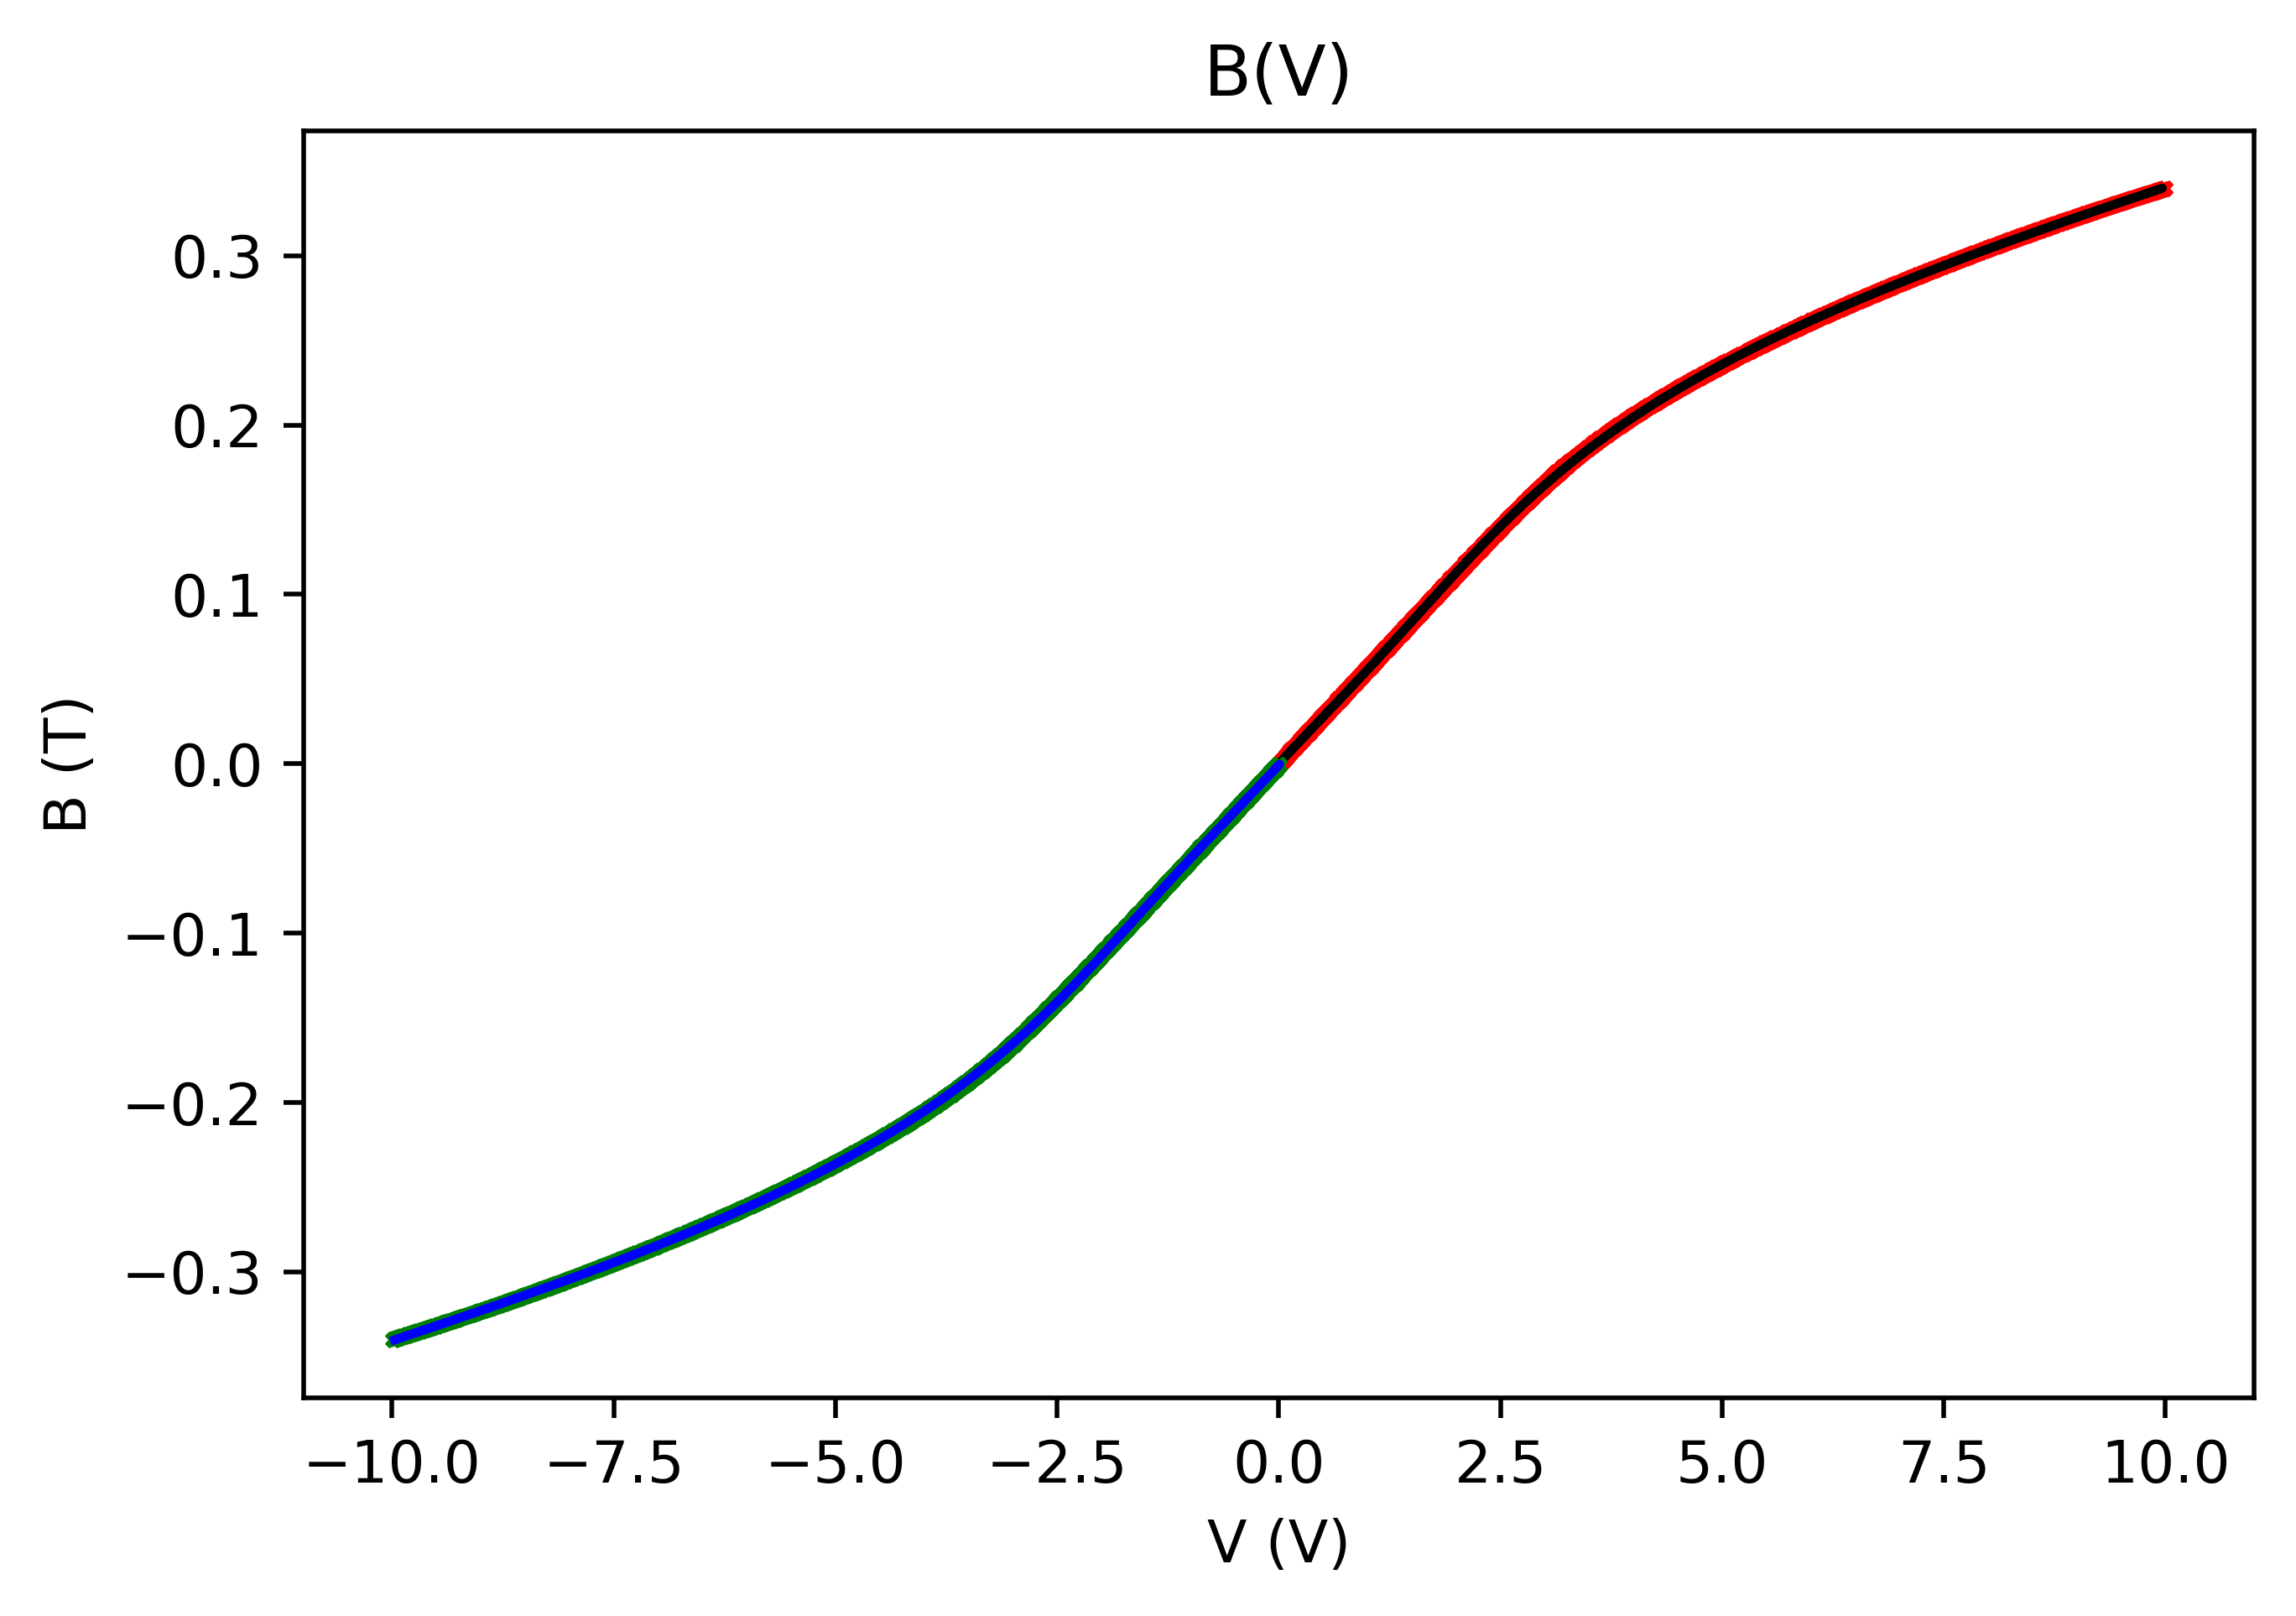

In [41]:
cen_vp_fit = np.poly1d(cen_vp_coeff)
cen_vn_fit = np.poly1d(cen_vn_coeff)
plt.figure(dpi=500)

plt.plot(cen_vp.V, cen_vp.Yfield, 'rx', markersize=2)
plt.plot(cen_vp_fit(cen_vp.Yfield), cen_vp.Yfield , 'k')

plt.plot(cen_vn.V, cen_vn.Yfield, 'gx', markersize=2)
plt.plot(cen_vn_fit(cen_vn.Yfield), cen_vn.Yfield , 'b')
plt.xlabel('V (V)')
plt.ylabel('B (T)')
plt.title('B(V)')

# Radial Calibration 2 V

In [42]:
vp = pd.read_csv('./2019-06-05/shims_convolved_centre_vp_daedalus_radialPolar_calib_A000.0_2019-06-05_1.csv', comment='#')
vn = pd.read_csv('./2019-06-05/shims_convolved_centre_vn_daedalus_radialPolar_calib_A000.0_2019-06-05_2.csv', comment='#')

In [43]:
vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

In [44]:
vp_dv = {}
vn_dv = {}
for c in vp.columns[:]:
    vp_dv[c] = (["R"],vp[c])
    vn_dv[c] = (["R"],vn[c])
vp_ds = xr.Dataset(vp_dv)
vn_ds = xr.Dataset(vn_dv)

### OOP field

In [18]:
vp_ds.where(abs(vp_ds.theta) == abs(vp_ds.theta).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 -3.197e-13
Data variables:
    Xfield        (R) float64 -0.001861
    Yfield        (R) float64 0.112
    Zfield        (R) float64 -4.628e-05
    elapsed_time  (R) float64 1.239e+03
    phi           (R) float64 -0.9523
    theta         (R) float64 -0.02368
    Bmag          (R) float64 0.112

In [19]:
vn_ds.where(abs(vn_ds.theta-90.0) == abs(vn_ds.theta-90.0).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 -13.9
Data variables:
    Xfield        (R) float64 0.002763
    Yfield        (R) float64 -0.002223
    Zfield        (R) float64 0.0671
    elapsed_time  (R) float64 147.4
    phi           (R) float64 128.8
    theta         (R) float64 88.1
    Bmag          (R) float64 0.06713

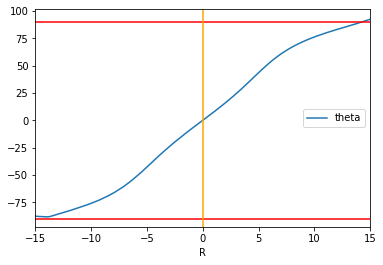

In [20]:
vp.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

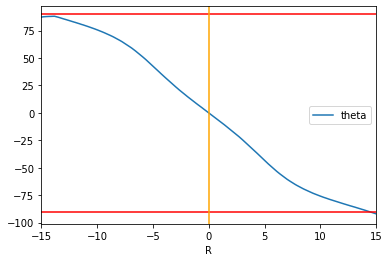

In [21]:
vn.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [45]:
vp_rp = vp[vp.R>0]
vp_rn = vp[vp.R<0]
vn_rp = vn[vn.R>0]
vn_rn = vn[vn.R<0]

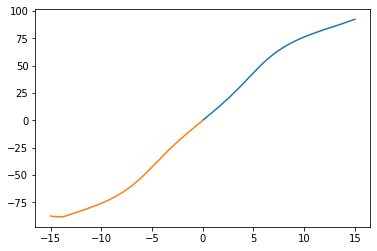

In [23]:
plt.plot(vp_rp.R, vp_rp.theta)
plt.plot(vp_rn.R, vp_rn.theta)

### Positive and Negative field discrepancy is <0.5$^\circ$ 

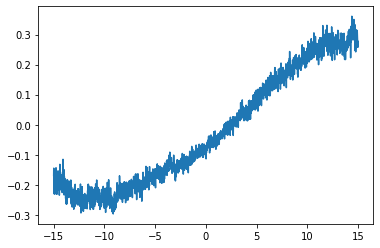

In [24]:
plt.plot(vp.R, (vp.theta+vn.theta))

### Positive voltage R-theta relation

In [46]:
vp_R_thetapos_coeff = np.polyfit(vp_rp.theta, vp_rp.R, 5)
vp_R_thetaneg_coeff = np.polyfit(vp_rn.theta, vp_rn.R, 5)
vp_R_thetapos = np.poly1d(vp_R_thetapos_coeff)
vp_R_thetaneg = np.poly1d(vp_R_thetaneg_coeff)
R_theta = vp_R_thetapos_coeff,vp_R_thetaneg_coeff
print(R_theta)
np.savetxt("./icarusCalibCsv/icarus_radial_polar_calib.csv", R_theta, delimiter=",")

(array([-6.17694642e-09,  1.61100636e-06, -1.23267984e-04,  3.26860846e-03,
        9.27655011e-02,  9.92108481e-02]), array([4.60423843e-09, 6.11725662e-07, 3.71797395e-05, 1.52180425e-03,
       1.47832107e-01, 4.56266327e-02]))


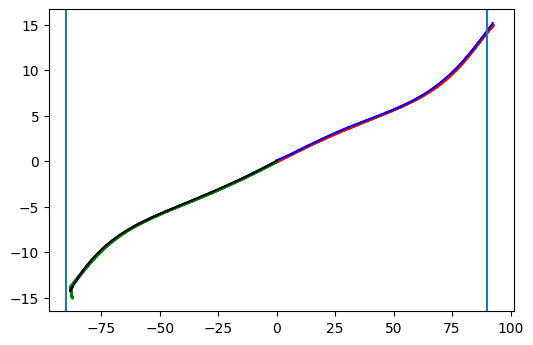

In [47]:
plt.figure(dpi=100)
plt.plot(vp_rp.theta, vp_rp.R, 'r+', markersize=2)
plt.plot(vp_rp.theta, vp_R_thetapos(vp_rp.theta), 'b')
plt.plot(vp_rn.theta, vp_rn.R, 'g+', markersize=2)
plt.plot(vp_rn.theta, vp_R_thetaneg(vp_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

In [48]:
bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

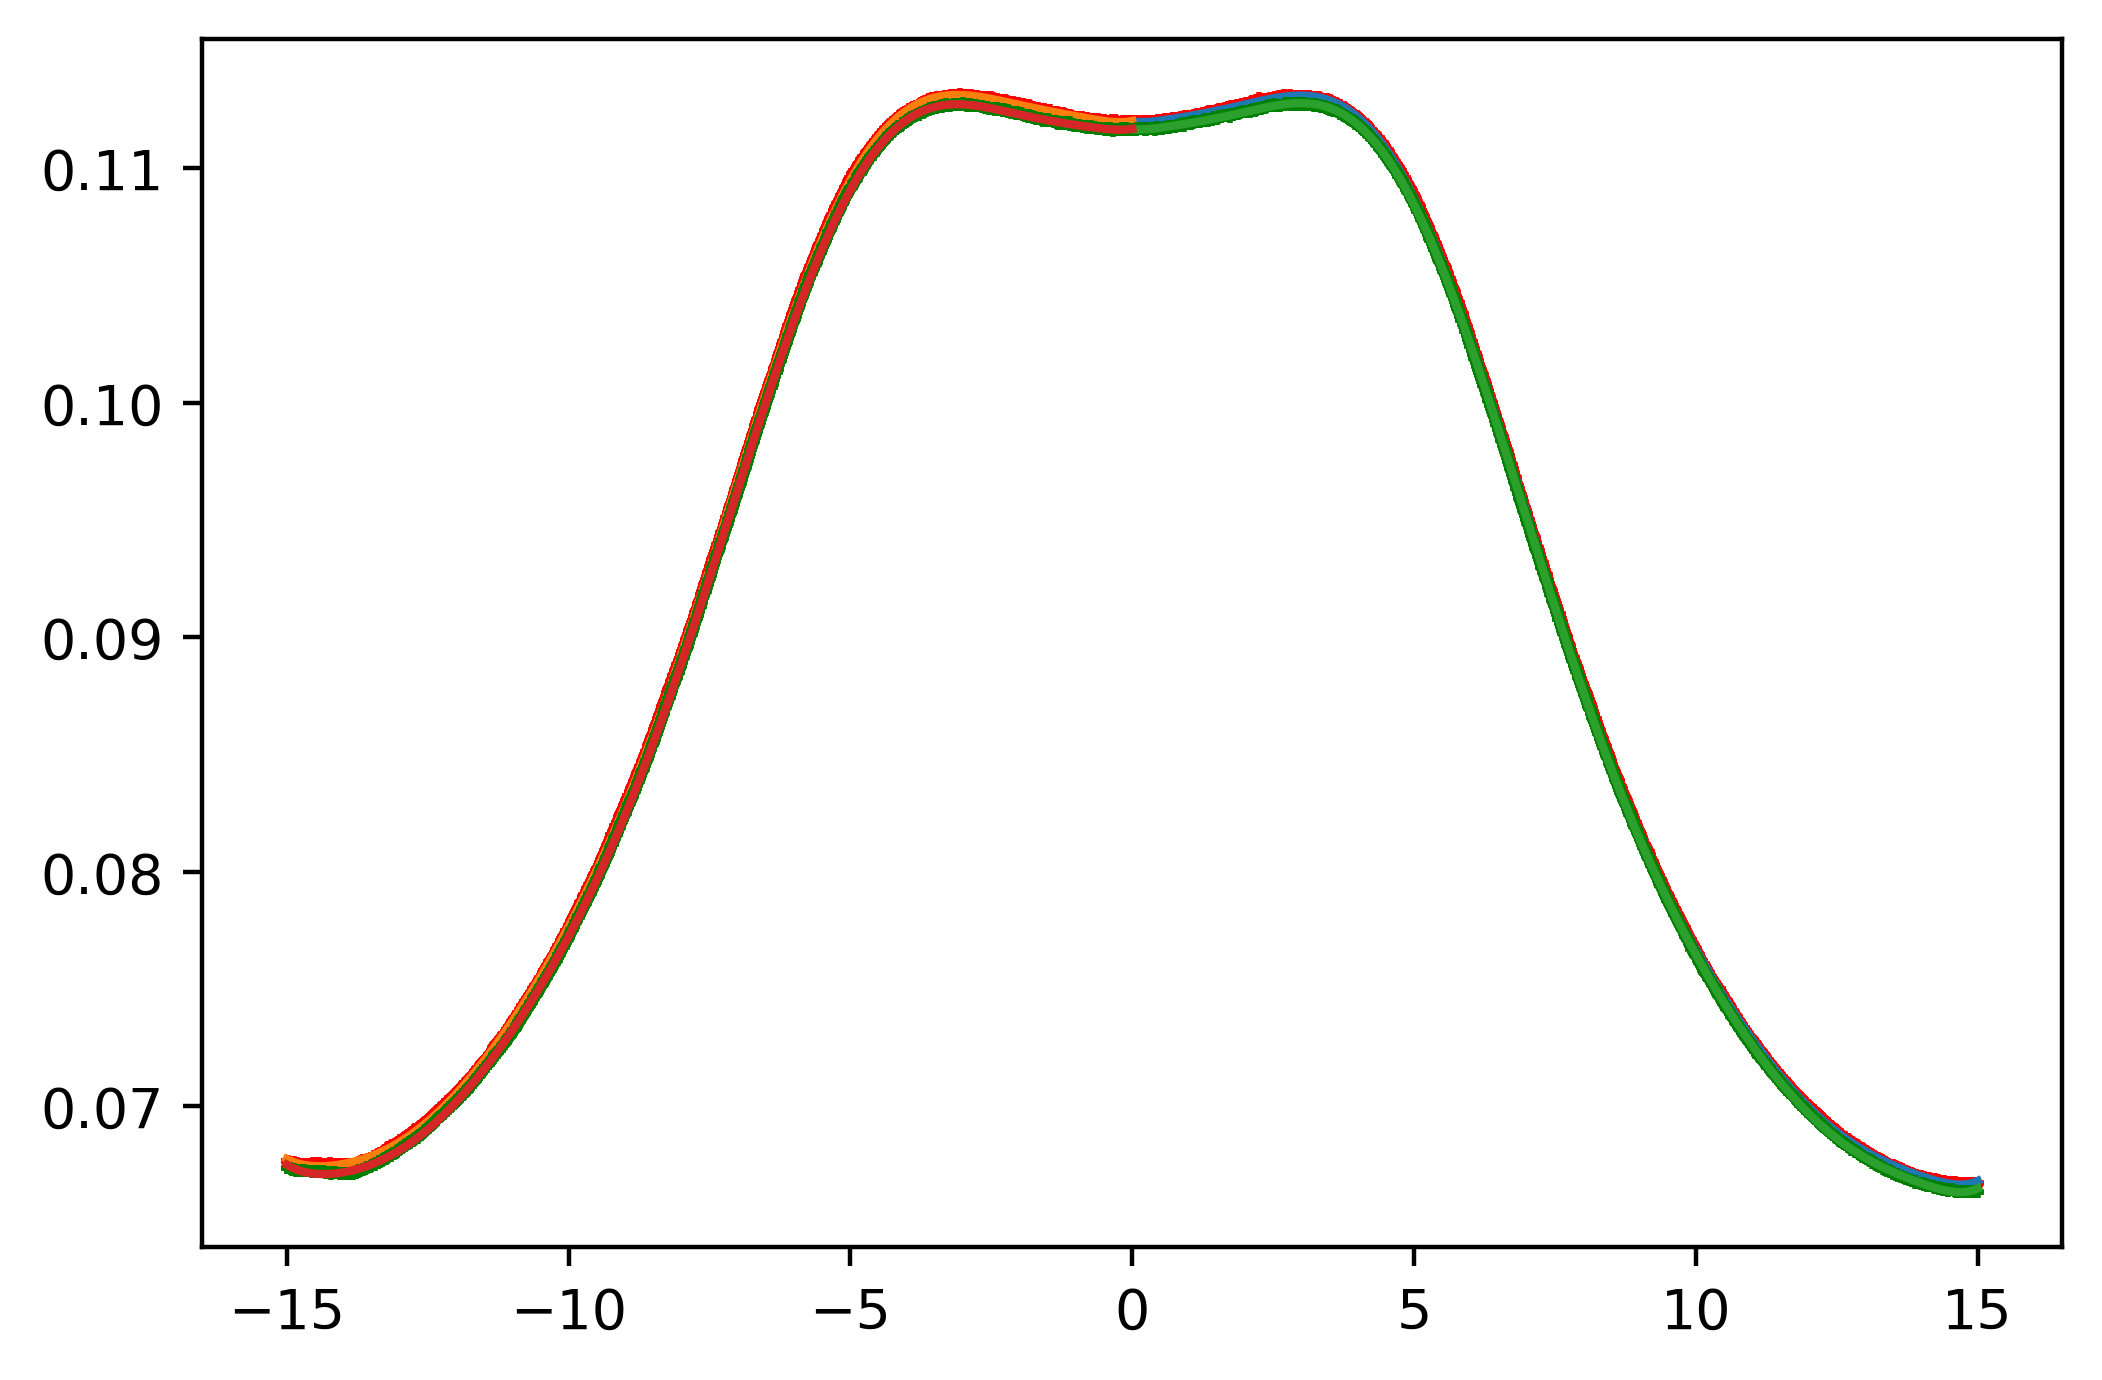

In [49]:
plt.figure(dpi=400)
plt.plot(vp.R, vp.Bmag, 'r+', markersize=2)
plt.plot(vp[vp.R>0].R, bmag_vp_rp(vp[vp.R>0].R))
plt.plot(vp[vp.R<0].R, bmag_vp_rn(vp[vp.R<0].R))
plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

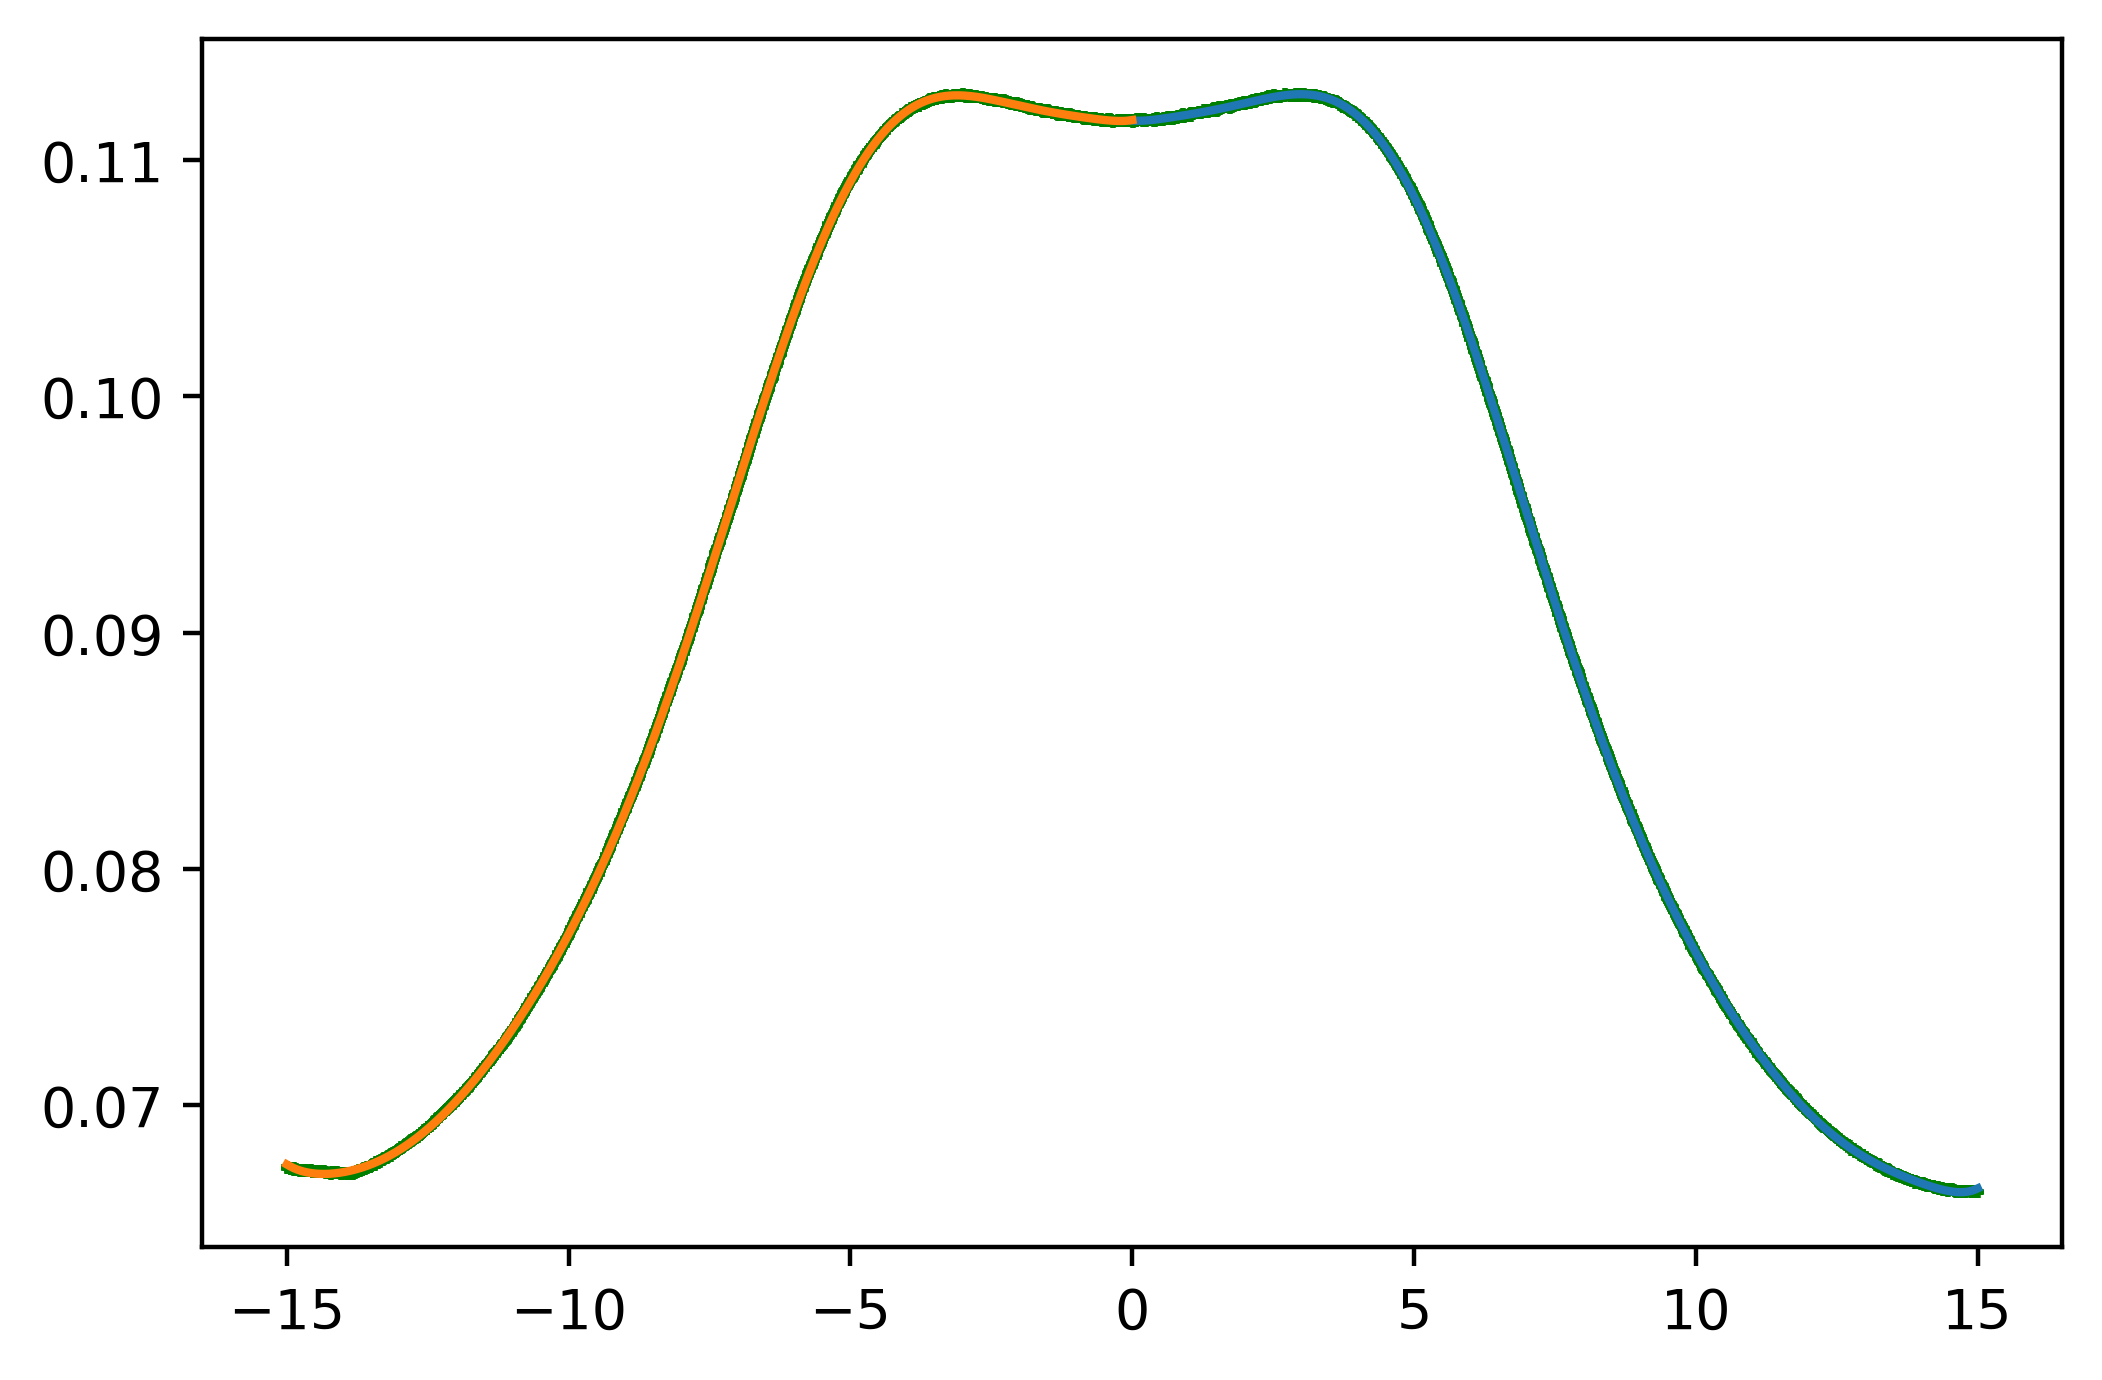

In [50]:
plt.figure(dpi=400)
plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

## Radial Calibration 5 V

In [21]:
vp = pd.read_csv('./2019-06-05/shims_convolved_centre_5vp_daedalus_radialPolar_calib_A000.0_2019-06-05_1.csv', comment='#')
vn = pd.read_csv('./2019-06-05/shims_convolved_centre_5vn_daedalus_radialPolar_calib_A000.0_2019-06-05_1.csv', comment='#')

In [22]:
vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

In [23]:
vp_dv = {}
vn_dv = {}
for c in vp.columns[:]:
    vp_dv[c] = (["R"],vp[c])
    vn_dv[c] = (["R"],vn[c])
vp_ds = xr.Dataset(vp_dv)
vn_ds = xr.Dataset(vn_dv)

In [24]:
vp_ds.where(abs(vp_ds.theta) == abs(vp_ds.theta).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 0.01
Data variables:
    Xfield        (R) float64 -0.003879
    Yfield        (R) float64 0.2356
    Zfield        (R) float64 0.0001205
    elapsed_time  (R) float64 1.246e+03
    phi           (R) float64 -0.9433
    theta         (R) float64 0.0293
    Bmag          (R) float64 0.2356

In [25]:
vn_ds.where(abs(vn_ds.theta-90.0) == abs(vn_ds.theta-90.0).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 -13.98
Data variables:
    Xfield        (R) float64 0.005782
    Yfield        (R) float64 -0.003536
    Zfield        (R) float64 0.1416
    elapsed_time  (R) float64 141.0
    phi           (R) float64 121.4
    theta         (R) float64 88.57
    Bmag          (R) float64 0.1416

In [26]:
vp_rp = vp[vp.R>0]
vp_rn = vp[vp.R<0]
vn_rp = vn[vn.R>0]
vn_rn = vn[vn.R<0]

## Positive Voltage R-theta relation 5 V

In [27]:
vp_R_thetapos_coeff = np.polyfit(vp_rp.theta, vp_rp.R, 5)
vp_R_thetaneg_coeff = np.polyfit(vp_rn.theta, vp_rn.R, 5)
vp_R_thetapos = np.poly1d(vp_R_thetapos_coeff)
vp_R_thetaneg = np.poly1d(vp_R_thetaneg_coeff)
R_theta = vp_R_thetapos_coeff,vp_R_thetaneg_coeff
print(R_theta)

(array([-6.16607494e-09,  1.60896717e-06, -1.22935561e-04,  3.24718167e-03,
        9.33075374e-02,  1.02834694e-01]), array([4.17204201e-09, 5.25234365e-07, 3.12317832e-05, 1.35794447e-03,
       1.46355291e-01, 4.43658819e-02]))


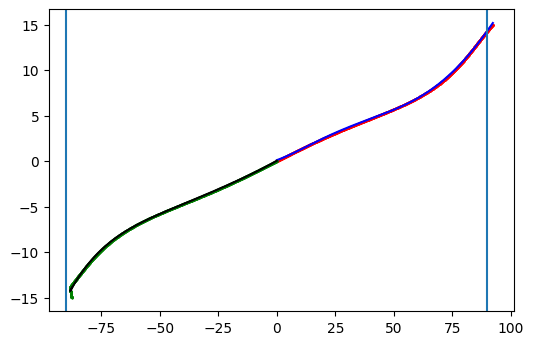

In [28]:
plt.figure(dpi=100)
plt.plot(vp_rp.theta, vp_rp.R, 'r+', markersize=2)
plt.plot(vp_rp.theta, vp_R_thetapos(vp_rp.theta), 'b')
plt.plot(vp_rn.theta, vp_rn.R, 'g+', markersize=2)
plt.plot(vp_rn.theta, vp_R_thetaneg(vp_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

In [29]:
bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

Text(0, 0.5, 'B (T)')

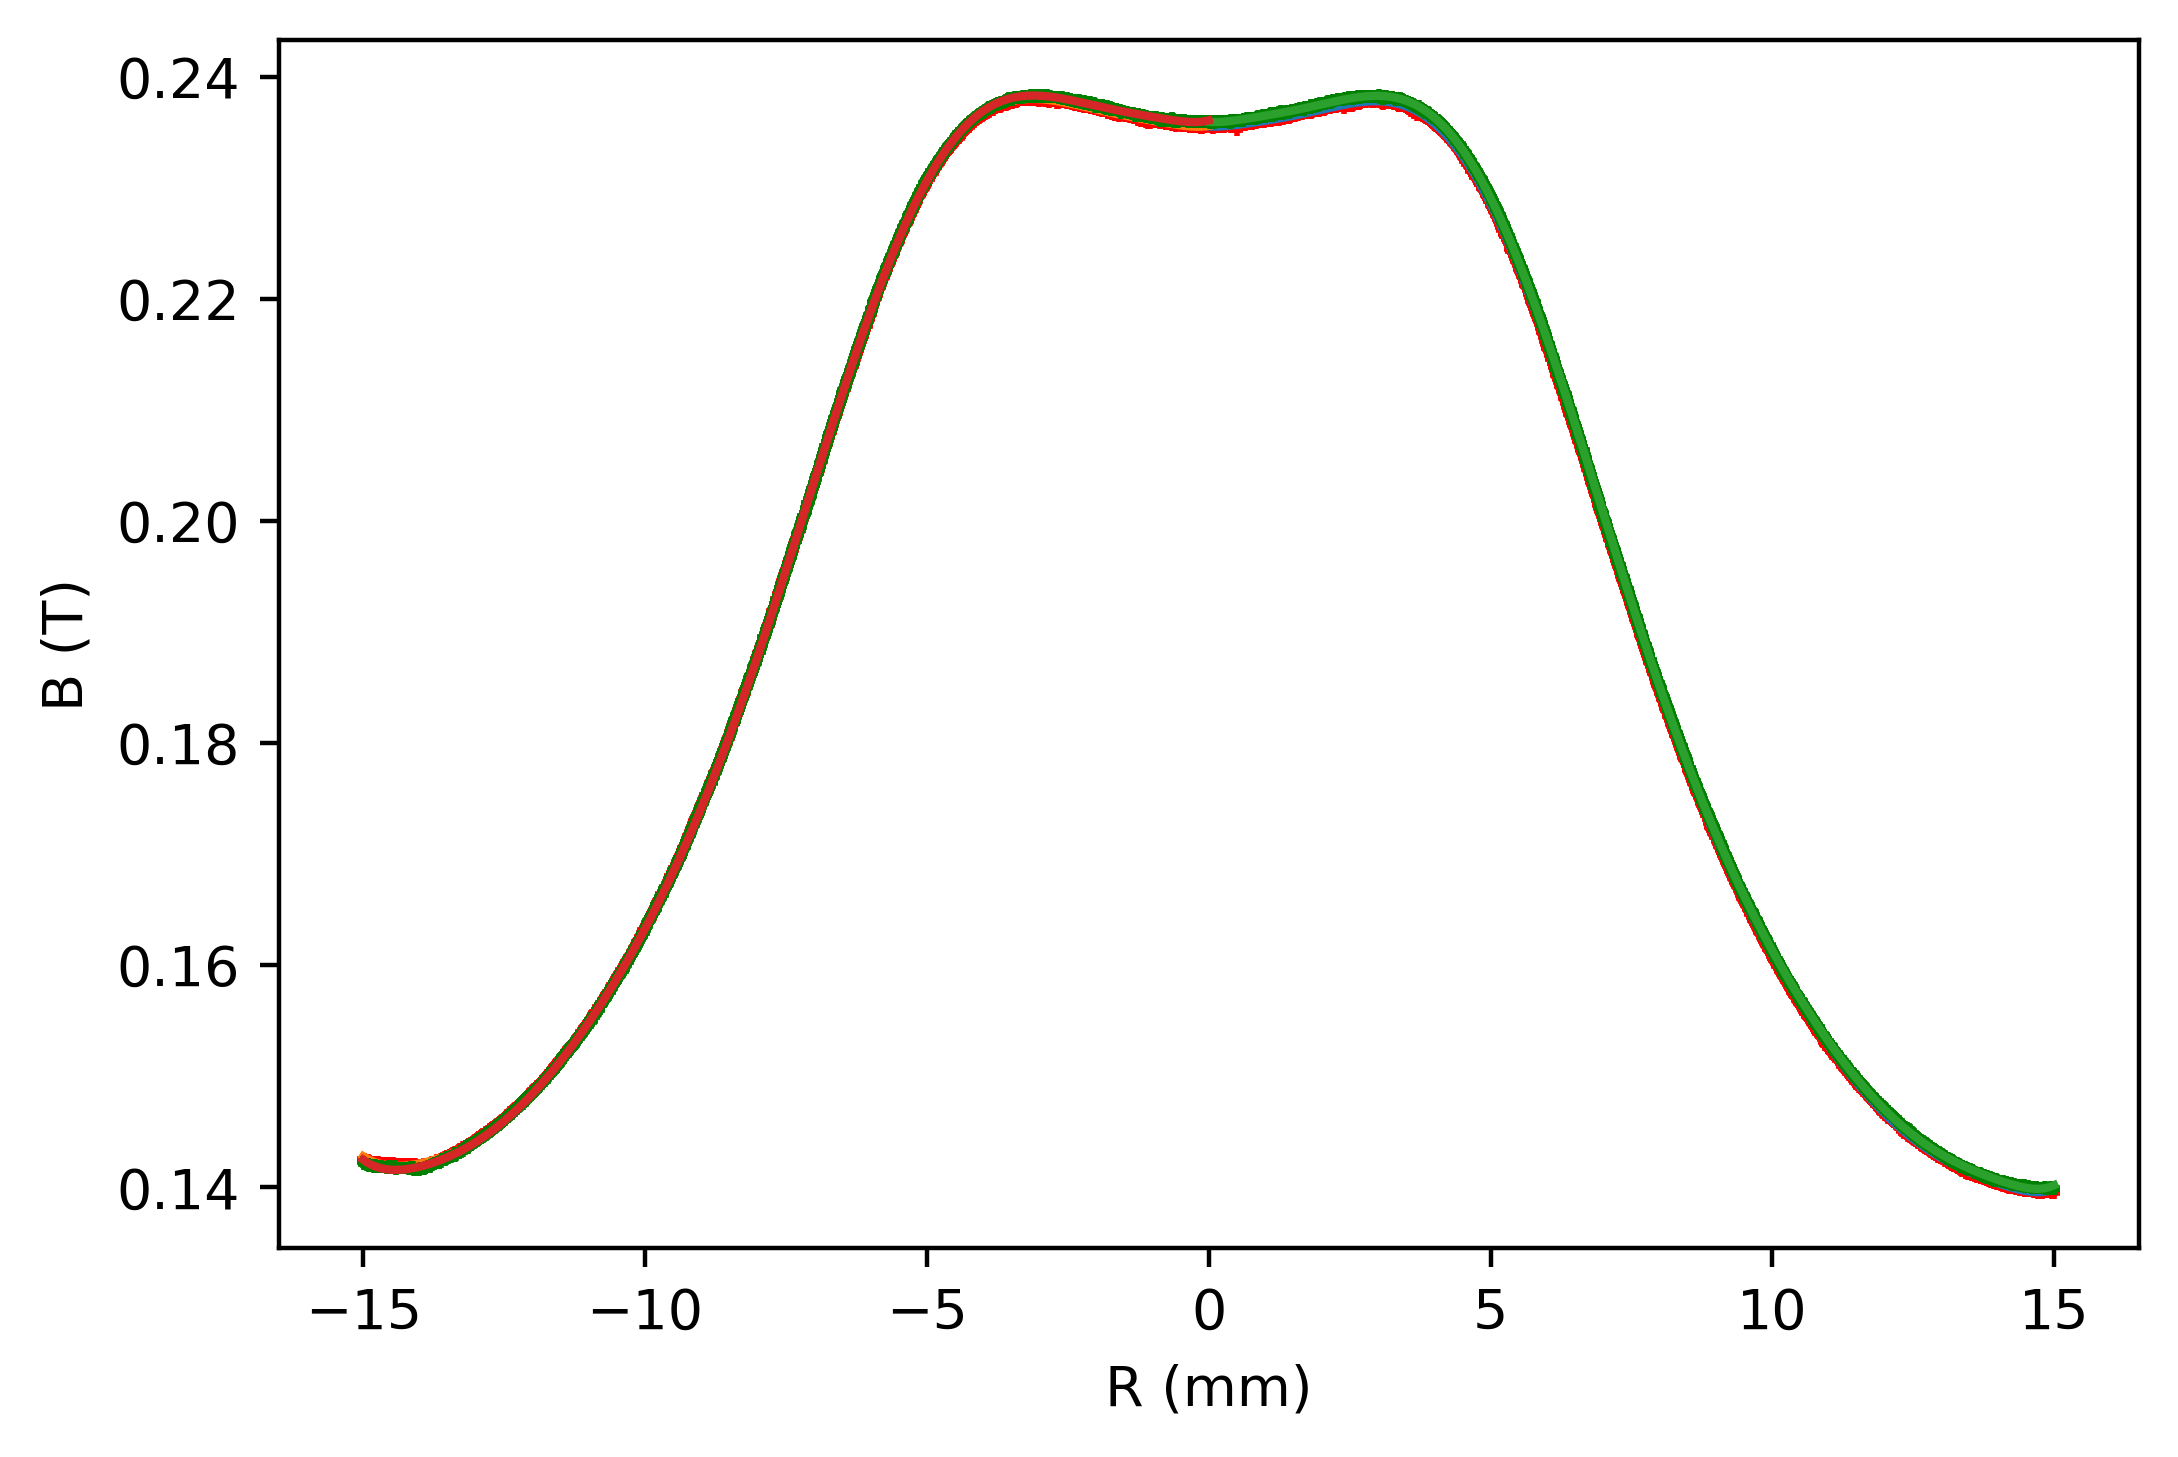

In [30]:
plt.figure(dpi=400)
plt.plot(vp.R, vp.Bmag, 'r+', markersize=2)
plt.plot(vp[vp.R>0].R, bmag_vp_rp(vp[vp.R>0].R))
plt.plot(vp[vp.R<0].R, bmag_vp_rn(vp[vp.R<0].R))
plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))
plt.xlabel('R (mm)')
plt.ylabel('B (T)')

### Voltage Correction function

In [51]:
V0 = 2.0 # Voltage used for radial scan
Rpts_p = np.arange(0, 15, 0.01)
Rpts_n = np.arange(-15, 0, 0.01)

In [52]:
vcent_vp_rp = V0/cen_vp_fit(bmag_vp_rp(Rpts_p))
vcent_vp_rn = V0/cen_vp_fit(bmag_vp_rn(Rpts_n))
vcent_vn_rp = -V0/cen_vn_fit(-bmag_vn_rp(Rpts_p))
vcent_vn_rn = -V0/cen_vn_fit(-bmag_vn_rn(Rpts_n))

In [53]:
n = 10
vcorr_vp_rp_coeff = np.polyfit(Rpts_p, vcent_vp_rp, n)
vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
vcorr_vp_rn_coeff = np.polyfit(Rpts_n, vcent_vp_rn, n)
vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
vcorr_vn_rp_coeff = np.polyfit(Rpts_p, vcent_vn_rp, n)
vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
vcorr_vn_rn_coeff = np.polyfit(Rpts_n, vcent_vn_rn, n)
vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

In [54]:
print(vcorr_vp_rp_coeff, '\n', vcorr_vp_rn_coeff, '\n', vcorr_vn_rp_coeff, '\n',vcorr_vn_rn_coeff)

[-8.38177164e-10  6.51325975e-08 -2.13996898e-06  3.84700613e-05
 -4.08339169e-04  2.57555033e-03 -9.37361035e-03  1.97745399e-02
 -2.35484928e-02  9.75023694e-03  1.00711513e+00] 
 [-5.39512107e-10 -4.46657925e-08 -1.55486893e-06 -2.94430033e-05
 -3.27154629e-04 -2.14486656e-03 -8.04234773e-03 -1.73228200e-02
 -2.09757321e-02 -8.59866166e-03  1.00726208e+00] 
 [-8.86380056e-10  6.83793737e-08 -2.23039942e-06  3.98079434e-05
 -4.19484783e-04  2.62507944e-03 -9.45565149e-03  1.96331590e-02
 -2.28759280e-02  9.07887315e-03  1.01419276e+00] 
 [-3.83674932e-10 -3.26376228e-08 -1.16221765e-06 -2.23773746e-05
 -2.50554218e-04 -1.63102527e-03 -5.93607402e-03 -1.23453711e-02
 -1.50500331e-02 -6.20445245e-03  1.01456733e+00]


In [34]:
vcorr_coeffs = [vcorr_vp_rp_coeff, vcorr_vn_rp_coeff, vcorr_vp_rn_coeff, vcorr_vn_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

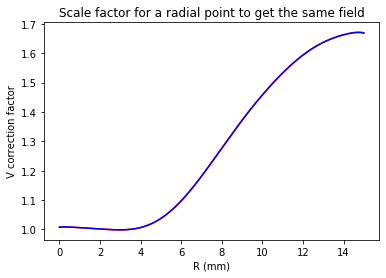

In [36]:
plt.plot(Rpts_p, vcent_vp_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')